In [1]:
import argparse
import time
import msgpack
import os.path
from enum import Enum, auto

import numpy as np
import math
import pickle

import matplotlib.pyplot as plt


from planning_utils import a_star, heuristic, create_grid, prune_path, create_grid_and_edges, a_starGraph, GetGraph, closest_point, GetGridAndOffsets, GetLat0Lon0, GetVoronoyGraph
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local, local_to_global

TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5

In [2]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

In [3]:
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [4]:
grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)

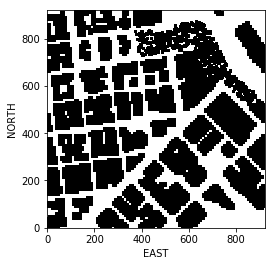

In [5]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')


plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

In [6]:
with open('colliders.csv', "r") as f:
    firstline = f.readline().split(',')

lat0 = float(firstline[0].split()[1])
lon0 = float(firstline[1].split()[1])

print(lat0)
print(lon0)

37.79248
-122.39745


In [8]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < self.get_waypoint_transition_threshold():
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()
                        
    def get_waypoint_transition_threshold(self):
        result = 1.0
        
        if len(self.waypoints) > 2:        
            velocity = np.linalg.norm(self.local_velocity[0:2])        
            result = 3*math.exp(-1/np.clip(velocity, 1, 10))
        
        print('threshold={}'.format(result))
        return result

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE
        
        # TODO: read lat0, lon0 from colliders into floating point values
        lat0, lon0 = GetLat0Lon0()
        
        # TODO: set home position to (lon0, lat0, 0)
        self.set_home_position(lon0, lat0, 0)

        # TODO: retrieve current global position
        global_position = self.global_position
 
        # TODO: convert to current local position using global_to_local()        
        local_position = global_to_local(global_position, self.global_home)
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        
        grid, north_offset, east_offset = GetGridAndOffsets()
        graph = GetVoronoyGraph()
        
        # Define starting point on the grid (this is just grid center)
        grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid        
        grid_goal = (250,720)# (-north_offset + 10, -east_offset + 10)
                
        
        # TODO: adapt to set goal as latitude / longitude position and convert
        local_position = global_to_local([-122.38925748, 37.79469147, 0.0], self.global_home)
        grid_goal = (int(local_position[0]), int(local_position[1]))        
        grid_goal = (700,120)# (-north_offset + 10, -east_offset + 10)

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        
        waypointsPath = self.GetPath(grid, graph, grid_start, grid_goal)
        if(waypointsPath is None):
            print("Path was not found")
            return
              
        self.waypoints = waypointsPath
        print(self.waypoints)
        self.send_waypoints()

    def GetPath(self, grid, graph, start, goal):
        start_g = closest_point(graph, start)
        goal_g = closest_point(graph, goal)
        print(goal_g)
        
        path, _ = a_starGraph(graph, heuristic, start_g, goal_g)
        # If it is not possible to find a path in graph, let's find a path in the grid
        if(path is None):
            print('Searching in grid')
            newpath, _ = a_star(grid, heuristic, start, goal)
            newpath = prune_path(newpath)
        else:            
            start_g = (int(start_g[0]), int(start_g[1]))
            goal_g = (int(goal_g[0]), int(goal_g[1]))
        
            pathToBegin, _ = a_star(grid, heuristic, start, start_g)
            pathFromEnd, _ = a_star(grid, heuristic, goal_g, goal)
        
            if(pathToBegin is None or pathFromEnd is None):
                return None
        
            newpath = pathToBegin + path + pathFromEnd
            newpath = prune_path(newpath)
        
        return [[int(p[0]) + north_offset, int(p[1]) + east_offset, TARGET_ALTITUDE, 0] for p in newpath]
    
    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        self.stop_log()

conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
drone = MotionPlanning(conn)
time.sleep(1)

drone.start()

Logs\TLog.txt
Logs\NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.39745   37.79248    0.     ], position [-122.3974506   37.7924785    0.137    ], local position [-0.15959488 -0.05563791 -0.13769141]
(707.4277666666666, 124.10183333333335)
Found a path.
Searching in grid
Found a path.
Found a path.
[[0, 0, 5, 0], [-1, 0, 5, 0], [-1, 0, 5, 0], [7, 0, 5, 0], [26, 14, 5, 0], [32, 17, 5, 0], [34, 15, 5, 0], [44, 5, 5, 0], [54, -2, 5, 0], [64, -7, 5, 0], [84, -12, 5, 0], [93, -16, 5, 0], [94, -17, 5, 0], [98, -18, 5, 0], [104, -25, 5, 0], [129, -40, 5, 0], [129, -65, 5, 0], [129, -65, 5, 0], [116, -85, 5, 0], [117, -92, 5, 0], [122, -105, 5, 0], [124, -115, 5, 0], [124, -135, 5, 0], [122, -147, 5, 0], [144, -155, 5, 0], [164, -155, 5, 0], [174, -158, 5, 0], [178, -161, 5, 0], [184, -162, 5, 0], [191, -160, 5, 0], [204, -165, 5, 0], [234, -165, 5, 0], [244, -168, 5, 0], [248, -171, 5, 0], [264, -175, 5, 0], [264, -175, 5, 0], [284, -175, 5, 0], [2

threshold=2.609416248970411
threshold=2.64212488607167
threshold=2.6168804134020767
waypoint transition
target position [184, -162, 5, 0]
threshold=2.556758218861576
threshold=2.5963304723223968
threshold=2.604404584794782
threshold=2.533035048171086
waypoint transition
target position [191, -160, 5, 0]
threshold=2.463944252315054
threshold=2.5378340906955836
threshold=2.5877569494085093
threshold=2.6019526962226376
threshold=2.5310474367941653
waypoint transition
target position [204, -165, 5, 0]
threshold=2.4177049772780643
threshold=2.4505264916634637
threshold=2.489545027124572
threshold=2.5261247061716863
threshold=2.565483310117919
threshold=2.6015772594928004
threshold=2.6289927395083295
threshold=2.6519841650053033
threshold=2.6137670995801137
waypoint transition
target position [234, -165, 5, 0]
threshold=2.5343275333673576
threshold=2.558180365895032
threshold=2.5813025167164376
threshold=2.609988570892099
threshold=2.642574880626791
threshold=2.6660779881655454
threshold=2.6

In [8]:
a = {'hello': 'world'}

with open('filename.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)
    
print(b)

{'hello': 'world'}


In [8]:
#from bresenham import bresenham

In [9]:
#from scipy.spatial import Voronoi

In [10]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
#import sys
#!{sys.executable} -m pip install -I networkx==2.1
#import pkg_resources
#pkg_resources.require("networkx==2.1")
#import networkx as nx

In [19]:
if os.path.isfile("Untitled1.ipynb") and os.path.isfile("setup.cfg"):
    print('does exist')
else:
    print('does not exist')

does exist
